# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusion](#conclusion)
- [Resources](#resources)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, you will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. You will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. You will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. **However, you do not need to download the data yourself.** The data has already been collected for you in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed for you. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. There is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze.

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## TODO: Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = list(csv.DictReader(f_in))
        
        ## TODO: Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = trip_reader[0]
        
        ## TODO: Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

You will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    """
    if city == 'Chicago' or city == 'NYC':
        # convert from seconds to minutes
        duration = float(datum['tripduration']) / 60
    elif city == 'Washington':
        # convert from millseconds to minutes
        duration = float(datum['Duration (ms)']) / 60000
    else: 
        print('City Not found: ', city)
   
    # print('{}: {}'.format(city, duration))
    
    return duration
    
# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    """
    columnStartTime = 'starttime'
    columnStartDate = 'Start date'
    dateFormat1 = '%m/%d/%Y %H:%M'
    dateFormat2 = '%m/%d/%Y %H:%M:%S'
    
    if city == 'Chicago':
        columnName = columnStartTime
        dateFormat = dateFormat1
    elif city == 'NYC':
        columnName = columnStartTime
        dateFormat = dateFormat2
    elif city == 'Washington':
        columnName = columnStartDate
        dateFormat = dateFormat1
    else:
        print('City Not found: ', city)       

    dateString = datum[columnName]
    dateObject = datetime.strptime(dateString, dateFormat)
    month = dateObject.month
    hour = dateObject.hour
    day_of_week = dateObject.strftime('%A')

    # print('City: {}'.format(city))
    # print('dateObject: {}'.format(dateObject))
    # print('month: {}'.format(month)        )
    # print('hour: {}'.format(hour))
    # print('day_of_week: {}'.format(day_of_week))
    # print('\n')
 
    return (month, hour, day_of_week)

# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
        
    # get column header and set user type
    if city == 'Chicago' or city == 'NYC':
        user_type = datum['usertype']
    elif city == 'Washington':
        if datum['Member Type'] == 'Registered':
            user_type = 'Subscriber'
        else:
            user_type = 'Customer'                
    else:
        print('City not found: ', city)
        
    # print("{}: {}".format(city, user_type))    
    
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    import csv
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## TODO: set up csv DictReader object ##
        trip_reader = list(csv.DictReader(f_in))

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            # print('time of trip: {}',  time_of_trip(row, city)[2])
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'] = time_of_trip(row, city)[0]
            new_point['hour'] = time_of_trip(row, city)[1]
            new_point['day_of_week'] = time_of_trip(row, city)[2]
            new_point['user_type'] = type_of_user(row, city)

            ## TODO: write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            # print('new point: {}', new_point)
            trip_writer.writerow(new_point)

In [7]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that you have the data collected and wrangled, you're ready to start exploring the data. In this section you will write some code to compute descriptive statistics from the data. You will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

New York has the highest number of trips, totaling 276,798 rides. New York also has the highest proportion of trips made by subscribers, approximately 89%. Chicago has the highest proportion of trips made by short-term customers, apporximately 24%.

In [8]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0

        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # proportion of trips made by subscribers -> subcripbers / total
        p_subscribers = (n_subscribers / n_total) * 100
        
        # proportion of trips made by customers -> customers / total
        p_customers = (n_customers / n_total) * 100
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total, p_subscribers, p_customers)

In [9]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##


example_file = './examples/BayArea-Y3-Summary.csv'

data_file = ['./data/Chicago-2016-Summary.csv',
             './data/NYC-2016-Summary.csv',
             './data/Washington-2016-Summary.csv']
for filepath in data_file:
    print(number_of_trips(filepath))

(54982, 17149, 72131, 76.22520136973007, 23.774798630269924)
(245896, 30902, 276798, 88.83590199351151, 11.164098006488485)
(51753, 14573, 66326, 78.0282242257938, 21.971775774206193)


Now, you will write your own code to continue investigating properties of the data.

Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. The average ride lenghts for Chicago, NYC, and Washington are 16.5 minutes, 15.8 minutes, and 18.9 minutes, respectively. Regarding rides greater than 30 miuntes, the proportions for Chicago, NYC, and Washington are 8.3%, 7.3%, and 10.8%, respectively.

In [10]:
def trip_length(filename):
    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        #initialize count variables
        trip_counter = 0
        trip_counter_30plus = 0
        duration_total = 0
        
        duration_subscribers = 0
        duration_customers = 0
        trip_counter_subscribers = 0
        trip_counter_customers = 0
        
        for row in reader:
            trip_counter += 1
            current_duration = float(row['duration'])
            if current_duration > 30:
                trip_counter_30plus += 1            
            duration_total += current_duration
            
            # duration of ride types
            if row['user_type'] == 'Subscriber':
                trip_counter_subscribers += 1
                duration_subscribers += current_duration
            else:
                trip_counter_customers += 1
                duration_customers += current_duration
                
        # average trip length
        average_duration = duration_total/trip_counter
        average_duration_subscribers = duration_subscribers / trip_counter_subscribers
        average_duration_customers = duration_customers / trip_counter_customers
        
        # proportions greater than 30 minutes
        p_30plus = (trip_counter_30plus / trip_counter)*100
    
        return (average_duration, p_30plus, average_duration_subscribers, average_duration_customers)

In [11]:
print(trip_length(example_file))

for filepath in data_file:
    print(trip_length(filepath))

(14.038656929671422, 3.5243689474519764, 9.512633839275217, 54.55121116377032)
(16.563629368787335, 8.332062497400562, 12.067201690250076, 30.979781133982506)
(15.81259299802294, 7.3024371563378345, 13.680790523907177, 32.77595139473187)
(18.93287355913721, 10.83888671109369, 12.528120499294745, 41.67803139252976)


I chose Chicago. Customers take longer rides on average (≈30.9 minutes) compared to subscribers (≈12.1 minutes). This was also true for NYC and Washington. I think another interesting question could build from this previous finding. Why are customer average rides 2 to 3 times longer than subscribers?

In [12]:
# print(trip_length(example_file))
print(trip_length('./data/Chicago-2016-Summary.csv'))

(16.563629368787335, 8.332062497400562, 12.067201690250076, 30.979781133982506)


<a id='visualizations'></a>
### Visualizations

The last set of values that you computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

<a id='libraries'></a>
#### Additional Libraries
- numpy: [Link](https://www.scipy.org/getting-started.html)
- pandas -> DataFrame: [Link](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)

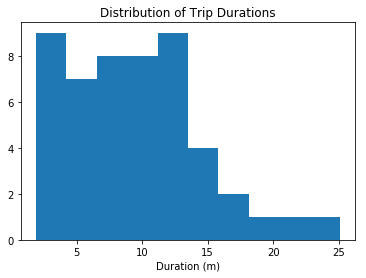

In [13]:
# load librarys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from pandas import DataFrame

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In [14]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##

def trip_times(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
    
        rides = []
        
        for row in reader:
            rides.append(float(row['duration']))
        return rides

#### Additional graph settings
- Arange: [Link](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html)
- Bins: [Link 1](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html)
- Bins: [Link 2](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html)
- Bins: [Link 3](https://www.youtube.com/watch?v=snkkKrek7TU)
- XLim: [Link](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.xlim.html#matplotlib.pyplot.xlim)
- XTick: [Link 1](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.xticks.html#matplotlib.pyplot.xticks)
- XTick: [Link 2](https://matplotlib.org/devdocs/gallery/lines_bars_and_markers/bar_stacked.html#sphx-glr-gallery-lines-bars-and-markers-bar-stacked-py)


In [15]:
# axis variables
min = 0
max = 75
step = 5

# set stop to 75 to exclude 75 and capture values less than 75
bins = np.arange(min, max, step)
# bin_edges = [1,25, 50, 75, 100, 125, 150, 175, 200, 250, 300]

In [16]:
# print(trip_times('./data/Chicago-2016-Summary.csv'))
data_chicago_allRides = trip_times('./data/Chicago-2016-Summary.csv')

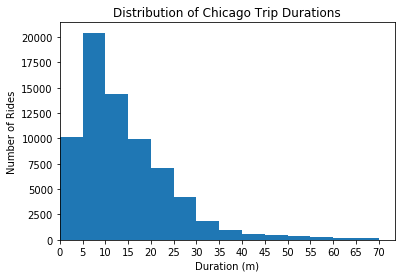

In [17]:
# I commented out the exercise plt.hist() below and added bins to the parameter
# plt.hist(data_chicago_allRides)
plt.hist(data_chicago_allRides, bins)
plt.xticks(bins)
plt.xlim(min)
plt.title('Distribution of Chicago Trip Durations')
plt.xlabel('Duration (m)')
plt.ylabel('Number of Rides')
plt.show()

The peak (mode) for Subscirbers is between 5-10 minutes, and Customers is between 20-25 minutes. Both the Subscriber and Customer charts look like they are right-skewed distribution. Even thought the Customer graph is a bit closer to normal distribution (when compared to the Subscriber graph), it is skewed to the right. Remember the mean values were calculated in question _4c_; approximately 12 minutes, and 30 minutes for subscribers, and customers, respectively. Both graphs display mode values aligned to the left of the mean values. The mean values are being pulled by the tail of the distribution. Furthermore, the graphs have taller bins on the left, and shorter bins on the right. These artifiacts are all indicators of right-skewed distribution.

#### Re-writing Code
I created the function _trip_\__times()_ for my first visualization exercise (above). Now I want to try something different to keep the code looking clean. [_pandas.read_\__csv()_](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) returns a _DataFrame_. _pandas.DataFrame_ has a method called _query_ that I want to run to capture specific data, rather than creating _if/elif/else_ conditions. What I'm not sure about is if I need to import DataFrame as this [link](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.query.html) describes. Above where I import the [libraries](#libraries), I'm going to leave _from pandas import DataFrame_ commented out unless I need to import it. I believe _DataFrame_ was imported with other libraries when I imported _pandas_.

In [18]:
data_chicago_allRides = pd.read_csv('./data/Chicago-2016-Summary.csv')

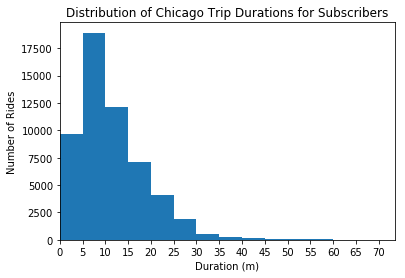

In [19]:
#subscribers visualization
data_chicago_subribers = data_chicago_allRides.query('user_type == "Subscriber"')
subscribers_below75 = data_chicago_subribers.query('duration < 75')
duration = subscribers_below75['duration']
plt.hist(duration, bins)
plt.xticks(bins)
plt.xlim(min)
plt.title('Distribution of Chicago Trip Durations for Subscribers')
plt.xlabel('Duration (m)')
plt.ylabel('Number of Rides')
plt.show()

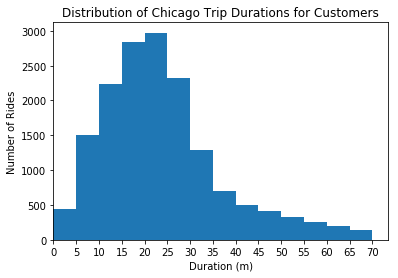

In [20]:
#customers visualization
data_chicago_customers = data_chicago_allRides.query('user_type == "Customer"')
customers_below75 = data_chicago_customers.query('duration < 75')
duration = customers_below75['duration']
plt.hist(duration, bins)
plt.xticks(bins)
plt.xlim(min)
plt.title('Distribution of Chicago Trip Durations for Customers')
plt.xlabel('Duration (m)')
plt.ylabel('Number of Rides')
plt.show()

<a id='eda_continued'></a>
## Performing Your Own Analysis

_How does ridership differ by month? Which month has the highest ridership? Does the percentage of Subscriber or Customer trips change depending on the month or season?_

I started with the big picture by looking at monthly ridership percentages, and provided 6 graphs to answer the questions above.

The first three cells are broken up by city. They house calculations and graphs that display the average ride lengths per user type for each month of the year. Chicago's highest ridership took place in July; customer's averaged 32.6 minutes, and subscribers averaged 13.5 minues. NYC's highest ridership varied; customer's averaged 41.4 minutes in June, and subscriber's averaged 14.6 minutes in April. Washington's highest ridership also varied; customer's averaged 45.7 minutes in April, and subscribers averaged 14.0 minutes June. Although the month for highest ridership is not consistant between cities, they all tend to have higher ridership in May and Jun for each user type. From there, the range of high ridership values hover around April to July, but these trends are not uniform, and vary slightly from city to city. The average ride lengths tend to be more consistant for subscribers throughout the year, while customers have higher peaks in spring and summer with a drop in value around the fall. 

The second set of cells are also broken up by city. They house calculations and graphs that display the percent of rides per user type for each month. Each graph follows a similar trend. Starting in January, the percent values increase till the peak around July, then decrease in value till December. In conclusion, this is only a snapshot of one year. More data points need to be gathered from other years to determine if there is a cylclal pattern or if there is a seasonal trend.

In [21]:
# read csv files
# chicago csv is above, variable declared as data_chicago_allRides
data_nyc_allRides = pd.read_csv('./data/NYC-2016-Summary.csv')
data_washington_allRides = pd.read_csv('./data/Washington-2016-Summary.csv')

In [22]:
#setting xtick values
x_months = [0,1,2,3,4,5,6,7,8,9,10,11]
labels_months = ['Jan', 'Feb', 'Mar', 
                 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sept', 
                 'Oct', 'Nov', 'Dec']

#### Visualizations: Averages

user_type   Customer  Subscriber
month                           
1          20.734677   10.243520
2          25.717032   10.842890
3          26.261563   10.571243
4          32.417306   12.120714
5          31.698940   12.660765
6          31.386932   13.026511
7          32.571868   13.497654
8          31.894674   12.446522
9          30.141872   11.846415
10         28.812701   11.321418
11         28.347326   11.101754
12         25.600000   10.642084


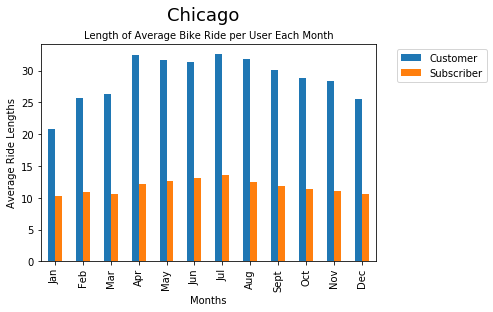

In [23]:
#chicago average rides per month
monthly_rides_chicago = data_chicago_allRides.groupby(['month','user_type']).mean()['duration'].unstack()
print(monthly_rides_chicago)
monthly_rides_chicago.plot(kind = 'bar', legend = 'user_type')

title_string = "Chicago"
subtitle_string = "Length of Average Bike Ride per User Each Month"
plt.suptitle(title_string, y=1.01, fontsize=18)
plt.title(subtitle_string, fontsize=10)

plt.xlabel('Months')
plt.ylabel('Average Ride Lengths')

plt.xticks(x_months,labels_months)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()

user_type   Customer  Subscriber
month                           
1          38.718784   13.058301
2          40.325747   14.078923
3          38.298580   13.606922
4          40.405509   14.636155
5          37.007453   14.428657
6          41.355028   14.210884
7          31.026590   13.015686
8          28.013633   13.695432
9          28.447853   13.573126
10         29.050931   13.064405
11         27.775672   14.246784
12         25.871016   12.362877


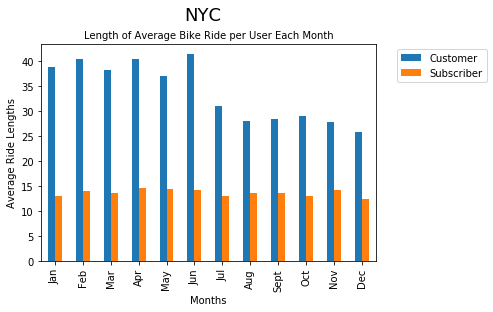

In [24]:
#nyc average rides per month
monthly_rides_nyc = data_nyc_allRides.groupby(['month','user_type']).mean()['duration'].unstack()
print(monthly_rides_nyc)
monthly_rides_nyc.plot(kind = 'bar', legend = 'user_type')

title_string = "NYC"
subtitle_string = "Length of Average Bike Ride per User Each Month"
plt.suptitle(title_string, y=1.01, fontsize=18)
plt.title(subtitle_string, fontsize=10)

plt.xlabel('Months')
plt.ylabel('Average Ride Lengths')

plt.xticks(x_months,labels_months)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()

user_type   Customer  Subscriber
month                           
1          37.188569   10.345552
2          32.917248   10.598818
3          44.751714   12.984291
4          45.665260   12.560703
5          44.325386   13.451142
6          44.061997   14.027611
7          44.458589   13.753074
8          36.825361   12.651764
9          40.504592   12.267442
10         39.719464   12.069564
11         39.803962   11.404771
12         35.701813   11.323556


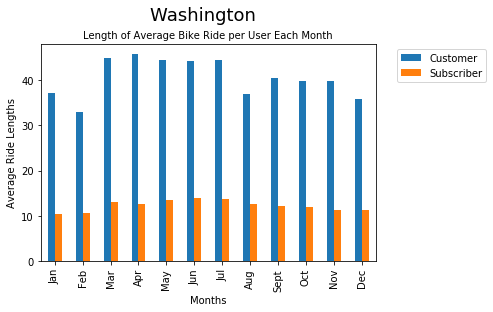

In [25]:
#washington average rides per month
monthly_rides_washington = data_washington_allRides.groupby(['month','user_type']).mean()['duration'].unstack()
print(monthly_rides_washington)
monthly_rides_washington.plot(kind = 'bar', legend = 'user_type')

title_string = "Washington"
subtitle_string = "Length of Average Bike Ride per User Each Month"
plt.suptitle(title_string, y=1.01, fontsize=18)
plt.title(subtitle_string, fontsize=10)

plt.xlabel('Months')
plt.ylabel('Average Ride Lengths')

plt.xticks(x_months,labels_months)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()

#### Visualizations: Percentages

The values for the next three graphs were easy to calculate. However, I had trouble initially setting up and aligning the items in these graphs, but was able to assemble the elements after reading through [_Matplotlib's_ resource on bar charts](https://pythonspot.com/matplotlib-bar-chart/).

month
1      0.361537
2      1.329524
3      3.294653
4      5.930375
5     11.732463
6     15.231209
7     19.377223
8     16.076739
9     13.726748
10     8.700216
11     3.889440
12     0.349875
Name: Customer, dtype: float64
month
1      3.344731
2      3.939471
3      5.736423
4      6.456659
5      9.455822
6     13.062457
7     12.664145
8     12.827835
9     11.541959
10    10.308828
11     7.537012
12     3.124659
Name: Subscriber, dtype: float64


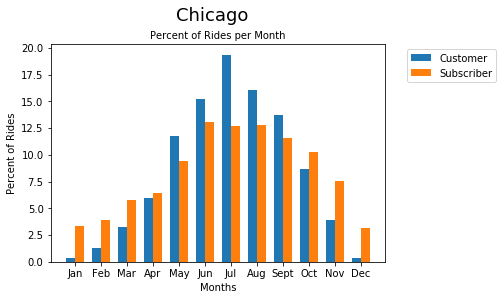

In [26]:
#chicago percent of subscribers:customers per month

#print(data_chicago_allRides)
count_user_type_rides_chicago = data_chicago_allRides.groupby(['month','user_type']).count()['duration'].unstack()
total_daily_rides_chicago = data_chicago_allRides.groupby(['user_type']).count()['duration']
percent_subscribers = (count_user_type_rides_chicago['Subscriber'] / total_daily_rides_chicago ['Subscriber']) * 100
percent_customers = (count_user_type_rides_chicago['Customer'] / total_daily_rides_chicago ['Customer']) * 100

print(percent_customers)
print(percent_subscribers)

fig, ax = plt.subplots()
index = np.arange(len(x_months))
bar_width = 0.35

customer_bars_chicago = plt.bar(index,
                                percent_customers,
                                bar_width,
                                label='Customer')

subscriber_bars_chicago = plt.bar(index+bar_width,
                                  percent_subscribers,
                                  bar_width,
                                  label='Subscriber')

title_string = "Chicago"
subtitle_string = "Percent of Rides per Month"
plt.suptitle(title_string, y=1.01, fontsize=18)
plt.title(subtitle_string, fontsize=10)

plt.xlabel('Months')
plt.ylabel('Percent of Rides')
plt.xticks(index + (bar_width/2), labels_months)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()


month
1      1.616697
2      1.885042
3      6.221633
4      8.719563
5     10.631108
6     10.389266
7     13.175418
8     14.616531
9     14.553586
10     9.958589
11     5.959914
12     2.272652
Name: Customer, dtype: float64
month
1      3.941504
2      4.311172
3      6.724388
4      7.128217
5      8.640238
6     10.616683
7      9.575186
8     10.854996
9     11.511371
10    11.443456
11     8.991200
12     6.261590
Name: Subscriber, dtype: float64


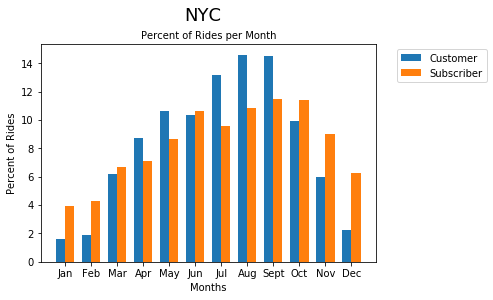

In [27]:
#nyc percent of subscribers:customers per month

#print(data_nyc_allRides)
count_user_type_rides_nyc = data_nyc_allRides.groupby(['month','user_type']).count()['duration'].unstack()
total_daily_rides_nyc = data_nyc_allRides.groupby(['user_type']).count()['duration']
percent_subscribers = (count_user_type_rides_nyc['Subscriber'] / total_daily_rides_nyc ['Subscriber']) * 100
percent_customers = (count_user_type_rides_nyc['Customer'] / total_daily_rides_nyc ['Customer']) * 100

print(percent_customers)
print(percent_subscribers)

fig, ax = plt.subplots()
index = np.arange(len(x_months))
bar_width = 0.35

customer_bars_nyc = plt.bar(index,
                                percent_customers,
                                bar_width,
                                label='Customer')

subscriber_bars_nyc = plt.bar(index+bar_width,
                                  percent_subscribers,
                                  bar_width,
                                  label='Subscriber')

title_string = "NYC"
subtitle_string = "Percent of Rides per Month"
plt.suptitle(title_string, y=1.01, fontsize=18)
plt.title(subtitle_string, fontsize=10)

plt.xlabel('Months')
plt.ylabel('Percent of Rides')
plt.xticks(index + (bar_width/2), labels_months)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()


month
1      1.523365
2      1.941947
3      8.152062
4      8.179510
5      8.563782
6     11.713443
7     15.000343
8     12.392781
9     11.486997
10    10.704728
11     7.376655
12     2.964386
Name: Customer, dtype: float64
month
1      4.274148
2      4.967828
3      8.469074
4      8.521245
5      8.733793
6     10.845748
7      9.960775
8     10.418720
9     10.055456
10    10.109559
11     7.997604
12     5.646050
Name: Subscriber, dtype: float64


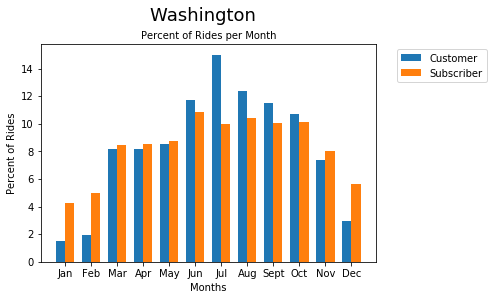

In [28]:
#washington percent of subscribers:customers per month

#print(data_washington_allRides)
count_user_type_rides_washington = data_washington_allRides.groupby(['month','user_type']).count()['duration'].unstack()
total_daily_rides_washington = data_washington_allRides.groupby(['user_type']).count()['duration']
percent_subscribers = (count_user_type_rides_washington['Subscriber'] / total_daily_rides_washington ['Subscriber']) * 100
percent_customers = (count_user_type_rides_washington['Customer'] / total_daily_rides_washington ['Customer']) * 100

print(percent_customers)
print(percent_subscribers)

fig, ax = plt.subplots()
index = np.arange(len(x_months))
bar_width = 0.35

customer_bars_washington = plt.bar(index,
                                percent_customers,
                                bar_width,
                                label='Customer')

subscriber_bars_washington = plt.bar(index+bar_width,
                                  percent_subscribers,
                                  bar_width,
                                  label='Subscriber')

title_string = "Washington"
subtitle_string = "Percent of Rides per Month"
plt.suptitle(title_string, y=1.01, fontsize=18)
plt.title(subtitle_string, fontsize=10)

plt.xlabel('Months')
plt.ylabel('Percent of Rides')
plt.xticks(index + (bar_width/2), labels_months)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()

In [29]:
## graph subscribers vs customers average rides individual days

<a id='conclusion'></a>
## Conclusion

_Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?_

This is a great question. I am an Instructional Designer, and transitioning into a Data Analyst role with empashis on _Learning & Performance_. It would be interesting to apply these techniques at my company (which is the goal). I could use these techniques to wrangle data from our various data sources (_e.g._ CMS's, LMS's, Salesforce,  etc.), clean the data, ensure there is a uniform format, and provide visuals that help senior management (plus myself) find insights related to training and its impact on performance in the real world. In turn, this will not only drive training, it will drive higher performance. I'm not sure if these techniques could also be used with interactive graphing software like Tableau or Domo. But if it can, I would like to learn how to utilize what I've learned with their APIs to manipulate, store, and track data in real-time.

Looking back, there is a lot of duplicated code in this project. If I where to redo this work, I'd utilize another library that would help make data manipulations easier and more efficient. The following example leverages _pandas_ and _seaborn_, with just a couple lines of code, to read data from Washington and make a plot of ridership broken down by Subscribers and Customers.

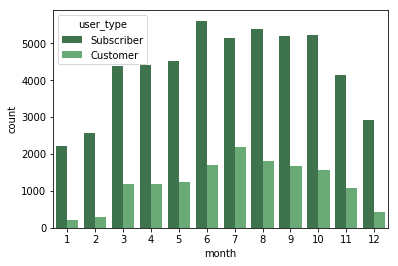

In [30]:
import seaborn as sns
dc = pd.read_csv('./data/Washington-2016-Summary.csv')
sns.countplot(x='month', data = dc, hue='user_type', palette='Greens_d')

<a id='resources'></a>
## Resources
- numpy: [Link](https://www.scipy.org/getting-started.html)
- pandas -> DataFrame: [Link](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)
- pandas.read_csv() [Link](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)
- DataFrame.query [Link](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.query.html)
- Matplotlib Bar Charts [Link](https://pythonspot.com/matplotlib-bar-chart/)

In [31]:
# convert file to html
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0